In [89]:
from mlxtend.data import loadlocal_mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
def show_image(e):
    if len(e.shape) > 2:
        e = e.reshape(28,28)
    plt.imshow(e, cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()

# Dataset


We're going to use the Kuzushiji dataset which is a dataset that 
contains 60000 training images and 10000 testing images in grayscale (one 
channel) and of size 28x28. Kuzushiji comes in MNIST original format (packed byte-encoded images), so we need a special function to read it.


The dataset comes in a binary form, so we need some special functions to load it. Details about the format can be found on
Yann LeCun's website http://yann.lecun.com/exdb/mnist/

In [3]:
X_train, y_train = loadlocal_mnist(
        images_path='kuzushiji/train-images-idx3-ubyte', 
        labels_path='kuzushiji/train-labels-idx1-ubyte')

In [4]:
X_test, y_test = loadlocal_mnist(
        images_path='kuzushiji/t10k-images-idx3-ubyte', 
        labels_path='kuzushiji/t10k-labels-idx1-ubyte')

In [5]:
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


We get the following structure:

- train: Training dataset
    + X: the predictors, 28x28 pixels image in grayscale.
    + y: the response
- test: Testing datset (with x and y)

## Response reencode


Notice that in y we have an integer from 0 to 9 (10 classes). They are in fact the following:
- 0: お - o
- 1: き - ki 
- 2: す - su 
- 3: つ - tsu
- 4: な - na
- 5: は - ha
- 6: ま - ma
- 7: や - ya
- 8: れ - re 
- 9: を - wo

Notice that the japanese symbols you see here (hiragana) are the modern ones.

In [6]:
class_ref = {
    0: "o",
    1: "ki",
    2: "su",
    3: "tsu",
    4: "na",
    5: "ha",
    6: "ma",
    7: "ya",
    8: "re",
    9: "wo"
}
def print_class(e, classes = class_ref):
    print(classes[e])

In [7]:
y_train_hot = pd.get_dummies(y_train)
y_test_hot = pd.get_dummies(y_test)

In [8]:
y_train_hot

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,1,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,1
59997,1,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,1,0,0,0,0,0


# Adding missing dimension

Convolutional layers will expect the input to have 4 dimensions:
- Sample dimension
- Height dimension
- Width dimension
- Channel dimension

In our case we have only one channel as the image is grayscale. If it's a color image we would have 3 or 4 channels (Red, Green, Blue and Alpha (transparency)). We need to add the missing dimension, however this will not modify the data. 

In [9]:
X_train = X_train.reshape((X_train.shape[0], 28, 28,  1))
X_test = X_test.reshape((X_test.shape[0], 28, 28,  1))

In [10]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Dataset visualization

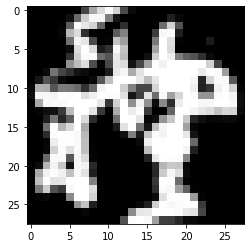

re


In [13]:
show_image(X_train[7])
print_class(y_train[7])

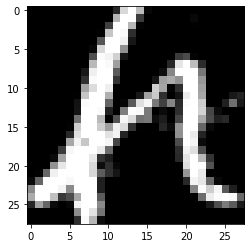

re


In [14]:
show_image(X_test[6])
print_class(y_test[6])

# Creating a dataset for MLP

In [11]:
X_train.shape[0], X_train.shape[1] ** 2 

(60000, 784)

In [57]:
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1] ** 2))
X_test_mlp = X_test.reshape((X_test.shape[0], X_test.shape[1] ** 2))

### Additional Tools

In [99]:
def print_acc(conf_mat):
    size = conf_mat.shape[1]
    ok = 0
    i = 0
    while i < size:
        ok += conf_mat[i,i]
        i += 1
    return(ok/sum(sum(conf_mat)))

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

#### We start by using Lenet Architecture:

In [14]:
lenet = keras.Sequential([
    # First convolutional block
    keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation="tanh",
        input_shape=(28,28,1), padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    # Second convolutional block
    keras.layers.Conv2D(filters=50, kernel_size=(5,5), activation="tanh",
        padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    # Flatten the matrix to a vector for the fully connected layers
    keras.layers.Flatten(),
    # First fully connected block
    keras.layers.Dense(units=500, activation="tanh"),
    # Second fully connected block
    keras.layers.Dense(units=10, activation="softmax")
    # This last layer will produce the final classification (probability of 
    # belonging to a class). 10 different units, 10 different classes.
])

In [15]:
lenet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2450)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               1225500   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [16]:
sgd = keras.optimizers.SGD(lr = 0.05, decay = 0.001, momentum = 0.8)

In [17]:
lenet.compile(
    optimizer = sgd,
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [18]:
history = lenet.fit(
    X_train, y_train_hot,
    batch_size = 50, validation_split = 0.2, epochs = 10
)

Epoch 1/10
960/960 [==============================] - 55s 57ms/step - loss: 0.4057 - accuracy: 0.8864 - val_loss: 0.1639 - val_accuracy: 0.9519
Epoch 2/10
960/960 [==============================] - 56s 59ms/step - loss: 0.0915 - accuracy: 0.9721 - val_loss: 0.1042 - val_accuracy: 0.9681
Epoch 3/10
960/960 [==============================] - 56s 58ms/step - loss: 0.0463 - accuracy: 0.9876 - val_loss: 0.0889 - val_accuracy: 0.9724
Epoch 4/10
960/960 [==============================] - 55s 58ms/step - loss: 0.0270 - accuracy: 0.9940 - val_loss: 0.0852 - val_accuracy: 0.9752
Epoch 5/10
960/960 [==============================] - 57s 59ms/step - loss: 0.0184 - accuracy: 0.9972 - val_loss: 0.0821 - val_accuracy: 0.9747
Epoch 6/10
960/960 [==============================] - 56s 58ms/step - loss: 0.0134 - accuracy: 0.9985 - val_loss: 0.0805 - val_accuracy: 0.9758
Epoch 7/10
960/960 [==============================] - 55s 57ms/step - loss: 0.0107 - accuracy: 0.9992 - val_loss: 0.0810 - val_accuracy:

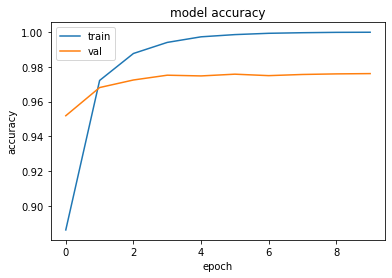

In [19]:
plot_history(history)

In [38]:
lenet.save("lenet-kuzushiji.h5")

In [22]:
lenet = load_model("lenet-kuzushiji.h5")

In [23]:
per_test = lenet.evaluate(X_test, y_test_hot)
print("Loss: {}, Accuracy: {}".format(per_test[0], per_test[1]))

313/313 [==============================] - 2s 6ms/step - loss: 0.2553 - accuracy: 0.9339
Loss: 0.25530871748924255, Accuracy: 0.933899998664856


In [24]:
pred_cnn = lenet.predict(X_test)

In [25]:
print(classification_report(y_test_hot.values.argmax(axis=1),
                            pred_cnn.argmax(axis=1),
                            target_names=class_ref.values()))

              precision    recall  f1-score   support

           o       0.94      0.95      0.94      1000
          ki       0.93      0.92      0.92      1000
          su       0.92      0.89      0.90      1000
         tsu       0.93      0.97      0.95      1000
          na       0.92      0.91      0.92      1000
          ha       0.96      0.92      0.94      1000
          ma       0.91      0.97      0.94      1000
          ya       0.96      0.93      0.94      1000
          re       0.93      0.95      0.94      1000
          wo       0.95      0.94      0.94      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [26]:
pd.DataFrame(
    confusion_matrix(
        y_test_hot.values.argmax(axis=1)
        ,pred_cnn.argmax(axis=1)
    ),
    index = class_ref.values(),
    columns = class_ref.values()
)

,o,ki,su,tsu,na,ha,ma,ya,re,wo
o,949,4,2,0,22,9,1,5,6,2
ki,3,915,15,0,9,3,37,1,7,10
su,9,6,889,35,5,12,13,14,10,7
tsu,3,4,12,969,2,3,4,0,1,2
na,23,6,1,8,909,7,10,8,24,4
ha,3,8,27,11,6,923,10,1,3,8
ma,3,2,11,3,7,1,967,3,2,1
ya,5,9,4,2,14,2,7,930,10,17
re,5,19,1,8,6,3,6,0,950,2
wo,7,8,9,2,6,3,6,11,10,938


#### Adding more Convolutional Layers:

In [151]:
convLenet = keras.Sequential([
    keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation="tanh",
        input_shape=(28,28,1), padding="same"),
    keras.layers.Conv2D(filters=50, kernel_size=(5,5), activation="tanh",
        padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=80, kernel_size=(5,5), activation="tanh",
        padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=110, kernel_size=(5,5), activation="tanh",
        padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(units=500, activation="tanh"),
    keras.layers.Dense(units=10, activation="softmax")
])

In [152]:
convLenet.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 28, 28, 20)        520       
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 28, 28, 50)        25050     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 14, 14, 50)        0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 14, 14, 80)        100080    
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 7, 7, 80)          0         
_________________________________________________________________
conv2d_119 (Conv2D)          (None, 7, 7, 110)         220110    
_________________________________________________________________
flatten_31 (Flatten)         (None, 5390)            

In [153]:
sgd = keras.optimizers.SGD(lr = 0.05, decay = 0.001, momentum = 0.8)

In [154]:
convLenet.compile(
    optimizer = sgd,
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [155]:
history5 = convLenet.fit(
    X_train, y_train_hot,
    batch_size = 50, validation_split = 0.2, epochs = 10
)

Epoch 1/10
960/960 [==============================] - 236s 245ms/step - loss: 1.3773 - accuracy: 0.6794 - val_loss: 0.4801 - val_accuracy: 0.8469
Epoch 2/10
960/960 [==============================] - 237s 247ms/step - loss: 0.3718 - accuracy: 0.8827 - val_loss: 0.3330 - val_accuracy: 0.8957
Epoch 3/10
960/960 [==============================] - 237s 246ms/step - loss: 0.2368 - accuracy: 0.9267 - val_loss: 0.2078 - val_accuracy: 0.9363
Epoch 4/10
960/960 [==============================] - 263s 274ms/step - loss: 0.1631 - accuracy: 0.9495 - val_loss: 0.1688 - val_accuracy: 0.9476
Epoch 5/10
960/960 [==============================] - 280s 292ms/step - loss: 0.1275 - accuracy: 0.9611 - val_loss: 0.1537 - val_accuracy: 0.9542
Epoch 6/10
960/960 [==============================] - 307s 320ms/step - loss: 0.1007 - accuracy: 0.9688 - val_loss: 0.1462 - val_accuracy: 0.9554
Epoch 7/10
960/960 [==============================] - 304s 316ms/step - loss: 0.0800 - accuracy: 0.9762 - val_loss: 0.1320 -

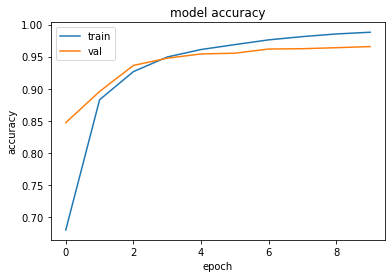

In [157]:
plot_history(history5)

In [159]:
per_test5 = convLenet.evaluate(X_test, y_test_hot)
print("Loss: {}, Accuracy: {}".format(per_test5[0], per_test5[1]))

313/313 [==============================] - 7s 23ms/step - loss: 0.2941 - accuracy: 0.9168
Loss: 0.2941133677959442, Accuracy: 0.9168000221252441


In [160]:
convLenet.save("convLenet.h5")

#### Let's try to add some Regularization:

In [143]:
arnaldNet = keras.Sequential([
    keras.layers.Conv2D(filters=20, kernel_size=(5,5), activation="tanh",
        input_shape=(28,28,1), padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    # Adding Regularization
    keras.layers.Dropout(rate = 0.25),
    keras.layers.Conv2D(filters=50, kernel_size=(5,5), activation="tanh",
        padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    # Adding Regularization
    keras.layers.Dropout(rate = 0.1),
    keras.layers.Conv2D(filters=100, kernel_size=(5,5), activation="tanh",
        padding="same"),
    keras.layers.Flatten(),
    # Adding 2 sequential Fully-Connected Layers:
    keras.layers.Dense(units=500, activation="tanh"),
    keras.layers.Dense(units=250, activation="tanh"),
    keras.layers.Dense(units=10, activation="softmax")
])

In [144]:
arnaldNet.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 28, 28, 20)        520       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 14, 14, 20)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 14, 14, 50)        25050     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 7, 7, 50)          0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 7, 7, 50)          0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 7, 7, 100)       

In [48]:
sgd = keras.optimizers.SGD(lr = 0.05, decay = 0.001, momentum = 0.8)

In [49]:
arnaldNet.compile(
    optimizer = sgd,
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [50]:
history2 = arnaldNet.fit(
    X_train, y_train_hot,
    batch_size = 50, validation_split = 0.2, epochs = 10
)

Epoch 1/10
960/960 [==============================] - 89s 93ms/step - loss: 0.4599 - accuracy: 0.8588 - val_loss: 0.1924 - val_accuracy: 0.9385
Epoch 2/10
960/960 [==============================] - 87s 91ms/step - loss: 0.1348 - accuracy: 0.9576 - val_loss: 0.1279 - val_accuracy: 0.9624
Epoch 3/10
960/960 [==============================] - 88s 92ms/step - loss: 0.0790 - accuracy: 0.9755 - val_loss: 0.1148 - val_accuracy: 0.9664
Epoch 4/10
960/960 [==============================] - 91s 95ms/step - loss: 0.0475 - accuracy: 0.9863 - val_loss: 0.0952 - val_accuracy: 0.9712
Epoch 5/10
960/960 [==============================] - 89s 93ms/step - loss: 0.0322 - accuracy: 0.9912 - val_loss: 0.0895 - val_accuracy: 0.9742
Epoch 6/10
960/960 [==============================] - 89s 92ms/step - loss: 0.0220 - accuracy: 0.9942 - val_loss: 0.0849 - val_accuracy: 0.9759
Epoch 7/10
960/960 [==============================] - 88s 92ms/step - loss: 0.0166 - accuracy: 0.9963 - val_loss: 0.0859 - val_accuracy:

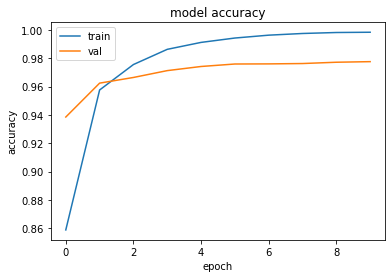

In [51]:
plot_history(history2)

In [ ]:
arnaldNet = load_model("arnaldNet_v1.h5")

In [52]:
per_test2 = arnaldNet.evaluate(X_test, y_test_hot)
print("Loss: {}, Accuracy: {}".format(per_test2[0], per_test2[1]))

313/313 [==============================] - 3s 10ms/step - loss: 0.2223 - accuracy: 0.9427
Loss: 0.2222558856010437, Accuracy: 0.9427000284194946


In [62]:
arnaldNet.save("arnaldNet_v1.h5")

#### Traditional MLP:

In [59]:
mlp_r = keras.Sequential([
    keras.layers.Dense(units = 128, activation = "relu", input_shape = (X_train_mlp.shape[1],)),
    keras.layers.Dropout(rate = 0.25),
    keras.layers.Dense(units = 64, activation = "relu"),
    keras.layers.Dropout(rate = 0.1),
    keras.layers.Dense(units = 32, activation = "relu"),
    keras.layers.Dropout(rate = 0.1),
    keras.layers.Dense(units = 16, activation = "relu"),
    keras.layers.Dropout(rate = 0.01),
    keras.layers.Dense(units = 10, activation = "softmax")
])

In [60]:
mlp_r.compile(
  loss = "categorical_crossentropy",
  optimizer = "rmsprop",
  metrics = ["accuracy"]
)

In [61]:
history3 = mlp_r.fit(
  X_train_mlp, y_train_hot,
  epochs = 100, batch_size = 128,
  validation_split = 0.2
)

Epoch 1/100
375/375 [==============================] - 1s 3ms/step - loss: 2.9621 - accuracy: 0.1292 - val_loss: 2.1606 - val_accuracy: 0.1566
Epoch 2/100
375/375 [==============================] - 1s 3ms/step - loss: 1.9830 - accuracy: 0.2663 - val_loss: 1.7636 - val_accuracy: 0.3171
Epoch 3/100
375/375 [==============================] - 1s 2ms/step - loss: 1.7130 - accuracy: 0.3544 - val_loss: 1.5190 - val_accuracy: 0.4145
Epoch 4/100
375/375 [==============================] - 1s 2ms/step - loss: 1.5320 - accuracy: 0.4159 - val_loss: 1.4031 - val_accuracy: 0.4740
Epoch 5/100
375/375 [==============================] - 1s 2ms/step - loss: 1.3808 - accuracy: 0.4791 - val_loss: 1.2104 - val_accuracy: 0.5257
Epoch 6/100
375/375 [==============================] - 1s 2ms/step - loss: 1.1797 - accuracy: 0.5626 - val_loss: 1.0074 - val_accuracy: 0.6219
Epoch 7/100
375/375 [==============================] - 1s 2ms/step - loss: 1.0419 - accuracy: 0.6178 - val_loss: 0.9241 - val_accuracy: 0.6529

Epoch 58/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1593 - accuracy: 0.9582 - val_loss: 0.2764 - val_accuracy: 0.9477
Epoch 59/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1603 - accuracy: 0.9587 - val_loss: 0.2582 - val_accuracy: 0.9450
Epoch 60/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1688 - accuracy: 0.9575 - val_loss: 0.2573 - val_accuracy: 0.9468
Epoch 61/100
375/375 [==============================] - 1s 4ms/step - loss: 0.1649 - accuracy: 0.9573 - val_loss: 0.2696 - val_accuracy: 0.9479
Epoch 62/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1584 - accuracy: 0.9595 - val_loss: 0.2673 - val_accuracy: 0.9469
Epoch 63/100
375/375 [==============================] - 1s 3ms/step - loss: 0.1594 - accuracy: 0.9592 - val_loss: 0.2557 - val_accuracy: 0.9476
Epoch 64/100
375/375 [==============================] - 1s 2ms/step - loss: 0.1604 - accuracy: 0.9607 - val_loss: 0.2985 - val_accuracy:

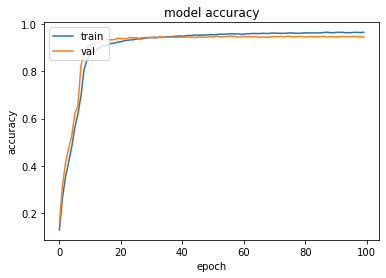

In [63]:
plot_history(history3)

In [ ]:
mlp_r = load_model("mlp_r_v1.h5")

In [65]:
per_test3 = mlp_r.evaluate(X_test_mlp, y_test_hot)
print("Loss: {}, Accuracy: {}".format(per_test3[0], per_test3[1]))

313/313 [==============================] - 0s 790us/step - loss: 0.7468 - accuracy: 0.8722
Loss: 0.7468260526657104, Accuracy: 0.8722000122070312


In [66]:
mlp_r.save("mlp_r_v1.h5")

#### Improving the MLP Regularized model:

In [73]:
mlp_r2 = keras.Sequential([
    keras.layers.Dense(units = 1024, activation = "relu", input_shape = (X_train_mlp.shape[1],)),
    keras.layers.Dropout(rate = 0.25),
    keras.layers.Dense(units = 512, activation = "relu"),
    keras.layers.Dropout(rate = 0.25),
    keras.layers.Dense(units = 256, activation = "relu"),
    keras.layers.Dropout(rate = 0.25),
    keras.layers.Dense(units = 128, activation = "relu"),
    keras.layers.Dropout(rate = 0.1),
    keras.layers.Dense(units = 64, activation = "relu"),
    keras.layers.Dropout(rate = 0.1),
    keras.layers.Dense(units = 32, activation = "relu"),
    keras.layers.Dropout(rate = 0.1),
    keras.layers.Dense(units = 16, activation = "relu"),
    keras.layers.Dropout(rate = 0.01),
    keras.layers.Dense(units = 10, activation = "softmax")
])

In [74]:
mlp_r2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_55 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_56 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_57 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)             

In [75]:
mlp_r2.compile(
  loss = "categorical_crossentropy",
  optimizer = "rmsprop",
  metrics = ["accuracy"]
)

In [80]:
history4 = mlp_r2.fit(
  X_train_mlp, y_train_hot,
  epochs = 100, batch_size = 128,
  validation_split = 0.2
)

Epoch 1/100
375/375 [==============================] - 12s 33ms/step - loss: 0.3639 - accuracy: 0.9129 - val_loss: 0.2807 - val_accuracy: 0.9378
Epoch 2/100
375/375 [==============================] - 12s 32ms/step - loss: 0.3068 - accuracy: 0.9294 - val_loss: 0.2435 - val_accuracy: 0.9437
Epoch 3/100
375/375 [==============================] - 11s 30ms/step - loss: 0.2791 - accuracy: 0.9371 - val_loss: 0.2254 - val_accuracy: 0.9507
Epoch 4/100
375/375 [==============================] - 12s 31ms/step - loss: 0.2554 - accuracy: 0.9419 - val_loss: 0.2230 - val_accuracy: 0.9497
Epoch 5/100
375/375 [==============================] - 14s 36ms/step - loss: 0.2443 - accuracy: 0.9455 - val_loss: 0.2113 - val_accuracy: 0.9507
Epoch 6/100
375/375 [==============================] - 12s 33ms/step - loss: 0.2334 - accuracy: 0.9494 - val_loss: 0.2476 - val_accuracy: 0.9520
Epoch 7/100
375/375 [==============================] - 12s 33ms/step - loss: 0.2157 - accuracy: 0.9532 - val_loss: 0.2103 - val_ac

In [84]:
mlp_r2.save("mlp_r_v2.h5")

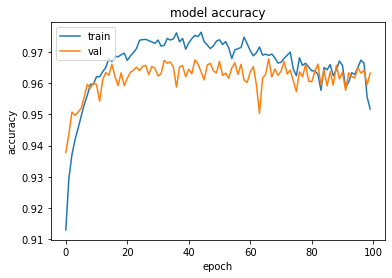

In [82]:
plot_history(history4)

In [ ]:
mlp_r2 = load_model("mlp_r_v2.h5")

In [83]:
per_test4 = mlp_r2.evaluate(X_test_mlp, y_test_hot)
print("Loss: {}, Accuracy: {}".format(per_test4[0], per_test4[1]))

313/313 [==============================] - 1s 3ms/step - loss: 1.2847 - accuracy: 0.9079
Loss: 1.284730315208435, Accuracy: 0.9078999757766724


In [85]:
pred_mlp = mlp_r2.predict(X_test_mlp)

In [86]:
print(classification_report(y_test_hot.values.argmax(axis=1),
                            pred_mlp.argmax(axis=1),
                            target_names=class_ref.values()))

              precision    recall  f1-score   support

           o       0.93      0.94      0.94      1000
          ki       0.92      0.90      0.91      1000
          su       0.85      0.87      0.86      1000
         tsu       0.80      0.97      0.88      1000
          na       0.94      0.87      0.90      1000
          ha       0.99      0.85      0.92      1000
          ma       0.86      0.93      0.89      1000
          ya       0.93      0.94      0.94      1000
          re       0.94      0.92      0.93      1000
          wo       0.96      0.89      0.93      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [87]:
pd.DataFrame(
    confusion_matrix(
        y_test_hot.values.argmax(axis=1)
        ,pred_mlp.argmax(axis=1)
    ),
    index = class_ref.values(),
    columns = class_ref.values()
)

,o,ki,su,tsu,na,ha,ma,ya,re,wo
o,940,3,2,6,13,0,2,25,9,0
ki,5,898,16,21,2,0,43,3,7,5
su,9,5,870,63,6,4,17,11,9,6
tsu,2,3,15,969,1,1,2,3,4,0
na,20,13,10,33,866,2,24,10,18,4
ha,3,15,52,25,3,853,31,2,6,10
ma,3,7,29,13,8,1,932,4,1,2
ya,7,5,9,17,4,1,11,940,1,5
re,6,12,12,33,0,0,15,2,919,1
wo,12,13,11,30,17,0,11,8,6,892


### Logistic Regression

In [93]:
log = LogisticRegression(max_iter=1000).fit(X_train_mlp, y_train)

C:\Users\Arnald\anaconda3\envs\Python_General\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [95]:
rf = RandomForestClassifier(n_estimators = 200, n_jobs=8).fit(X_train_mlp, y_train)

In [97]:
pred_rf = rf.predict(X_test_mlp)
t_rf = confusion_matrix(y_test, pred_rf)

In [104]:
pd.DataFrame(t_rf, index = class_ref.values(), columns = class_ref.values())

,o,ki,su,tsu,na,ha,ma,ya,re,wo
o,883,2,1,2,21,15,1,43,28,4
ki,6,861,22,1,20,4,52,3,11,20
su,9,25,831,37,11,6,29,15,18,19
tsu,4,12,12,944,2,0,2,2,6,16
na,47,28,13,13,823,2,19,11,38,6
ha,6,20,77,12,12,832,28,1,8,4
ma,3,19,21,3,22,1,916,5,3,7
ya,10,31,13,3,86,1,18,765,50,23
re,7,25,8,22,1,8,17,2,905,5
wo,10,14,32,3,35,1,0,39,13,853


In [105]:
print_acc(t_rf)

0.8613